## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape  # pandas dataframe

(70000, 784)

In [3]:
y.shape  # series

(70000,)

共70000张图片，每张图片784=28*28个特征

显示一张图片：

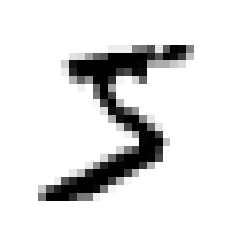

In [4]:
import matplotlib.pyplot as plt
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# 将y中的元素从字符串类型改为数值类型
import numpy as np
y = y.astype(np.uint8)

In [7]:
# 样本切分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 训练二分类器

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

随机梯度下降
- 一次训练一条样本
- 适合在线学习
- 能够有效处理非常大型的数据集

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])


array([ True])

## 性能评估

- 用 StratifiedKFold 函数来评估SGDClassifier模型：
- StratifiedKFold 比 cross_val_score 能够更加灵活地控制交叉验证
- 每个折叠由 StratifiedKFold 执行分层抽样产生，其所包含的各个类的比例符合整体
- 评估指标先选择“准确率”

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index, :]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train.iloc[test_index, :]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495
    print()

0.9669

0.91625

0.96785



In [11]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [12]:
accuracy_score(y_train_5, y_train_pred)

0.9570333333333333

- 以上交叉验证都表明，这个二分类问题模型的准确率为 95% 左右
- 但是如果构造一个分类器把所有样本都分成“非5”，其准确率也有90%
- 说明准确率通常无法成为分类器的首要性能指标，特别是当处理有偏数据集时

In [13]:
# 把所有样本都分成“非5”的分类器
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

评估分类器性能的更好方法是混淆矩阵：
- 混淆矩阵中的行表示实际类别，列表示预测类别


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

[[53892,   687],

 [ 1891,  3530]]

解释：
- 所有“非5”（负类）的图片中：53892张被正确地分为“非5”类别（真负类），687张被错误地分类成了“5”（假正类）
- 所有“5”（正类）的图片中：1891张被错误地分为“非5”类别（假负类），3530张被正确地分在了“5”这一类别（真正类）


混淆矩阵中包含了大量的信息，以下指标更加简洁一些：

$精确率=\frac{TP}{TP+FP}=\frac{预测为正例且预测正确的数量}{预测为正例的数量}$
$召回率=\frac{TP}{TP+FN}=\frac{预测为正例且预测正确的数量}{真正的正例的数量}$


In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)  # 0.8370879772350012

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)  # 0.6511713705958311

0.6511713705958311

- 当分类器认为一张图片为5时，有83.7%的概率预测对了
- 只有65.1%的数字5被它检测出来了

F1-score：
- $F1=\frac{2}{\frac{1}{精确率}+\frac{1}{召回率}}=2\frac{精确率*召回率}{精确率+召回率}$
- F1是一个将精确率与召回率组合起来的一个单一的指标
- F1是精确率与召回率的谐波平均值
- 普通的平均值会平等对待所有值，谐波平均值会给低值赋予更高的权重
- F1分数对那些具有相近的精度和召回率的分类器更为有利

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 不同的阈值会使得分类器具有不同的精确率与召回率
- Scikit-Learn不允许直接设置阈值
- 但是可以调用decision_function()方法来查看决策的分数

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
# 自己设置阈值
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

### 如何决定阈值
1. 不同阈值对应不同精确率和召回率

In [20]:
#  1.使用cross_val_predict()函数获取训练集中所有实例的分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

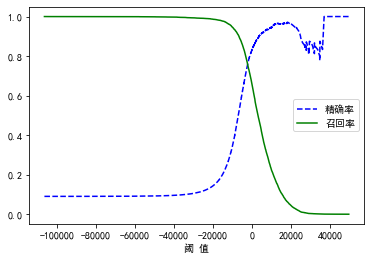

In [21]:
#  2.使用precision_recall_curve（）函数来计算所有可能的阈值的精度和召回率
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#  3. 绘制精度和召回率相对于阈值的函数图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    plt.plot(thresholds, precisions[:-1], "b--", label="精确率")
    plt.plot(thresholds, recalls[:-1], "g-", label="召回率")
    plt.xlabel('阈 值')  # Add an x-label to the axes.
    plt.legend()  # Add a legend.

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

注意：
- 当阈值上升时，精确率可能下降
- 如下图所示，当中间阈值右移一位时，精确率将从4/5降低为3/4
- 当阈值上升时，召回率不可能上升，只会下降或不变

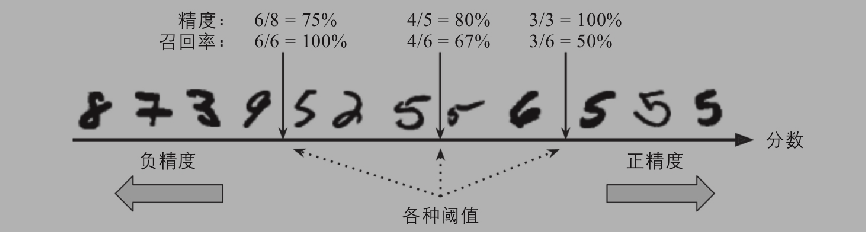

In [22]:
from IPython.display import Image
Image(filename = 'picture/precisions_and_recalls_for_thresholds.png', width=100, height=60)


2. 从召回率和精确率的函数图（PR曲线）中寻找合适的阈值

可以看到，当召回率大于0.8时，精确率急速下降

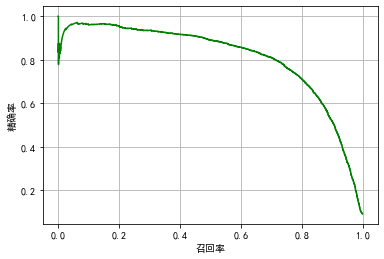

In [23]:
def plot_precision_recall(precisions, recalls):
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    plt.plot(recalls[:-1], precisions[:-1], "g-")
    plt.grid(True)
    plt.xlabel('召回率')  # Add an x-label to the axes.
    plt.ylabel('精确率')  # Add an x-label to the axes.

plot_precision_recall(precisions, recalls)
plt.show()

3. 从真正例率（召回率）和假正例率中寻找合适的阈值

    - $真正例率TPR=\frac{TP}{TP+FN}=\frac{预测为正例且预测正确的数量}{真正的正例的数量}$
    - $假正例率FPR=\frac{FP}{TN+FP}=\frac{预测为正例且实际为负例的数量}{真正的负例的数量}$
    - 该曲线为ROC曲线
    - 表明了召回率TPR越高，分类器产生的假正例率FPR也越高
    - ROC曲线下的面积AUC表明：随机拿一个正例和负例，正例得分大于负例的概率

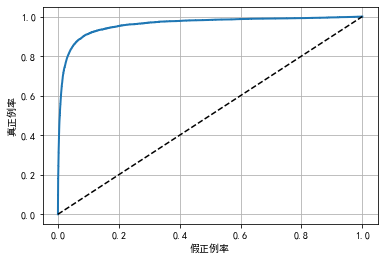

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.grid(True)
    plt.xlabel('假正例率')  # Add an x-label to the axes.
    plt.ylabel('真正例率')  # Add an x-label to the axes.

plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
#  计算AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

对于这个分类器，PR曲线效果不行，而ROC曲线效果很好

PR曲线和ROC曲线该如何选择：
- 当正例很少见选择PR曲线，否则选择ROC曲线
- 正例很少时，负例很多，当取一个较高的召回率时假正例率不会很大

### 训练一个RandomForestClassifier分类器
并比较它和SGDClassifier分类器的ROC曲线和ROC AUC分数

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
print(y_probas_forest)
print(y_train_5)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]
0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool


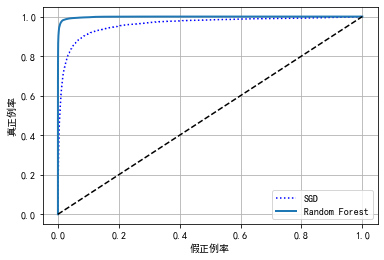

In [27]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 多分类器
- 多分类算法由多个二分类器组成，有`一对一`、`一对剩余`两种策略
- SVM是一种二分类算法，使用它进行多分类任务时，默认使用`一对一`策略
- 分别是区分0和1、0和2、1和2...
- 共45个二分类器


In [29]:
# 使用二元分类算法进行多类分类任务，sklearn会根据情况自动选择为：
# N×（N-1）/2个 或 N 个分类器
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

验证svm_clf是怎样做决策的

调用decision_function，将返回10个分数

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [31]:
# 最大分数的索引
np.argmax(some_digit_scores)

5

In [32]:
# 每个索引对应的类别
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

可以发现最大分数索引(5)对应的类别为5

强制sk-learn使用`一对一`或`一对剩余`策略：
- OneVsOneClassifier: 一对一策略
- OneVsRestClassifier: 一对剩余策略

换一个模型，使用SGDClassifier，进行准确率评估

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_pred)

0.8669666666666667

对特征进行标准化缩放，使用SGDClassifier，再进行准确率评估

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

accuracy_score(y_train, y_train_pred)

0.8970333333333333

## 误差分析
为了进一步改进现有模型，需要进行模型预测的错误分析

In [35]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

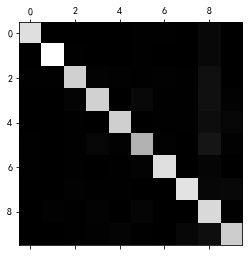

In [36]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

主对角线上，数字5比较小，可能是：
- 数据集中数字5比较少
- 分类器对数字5预测得不够好

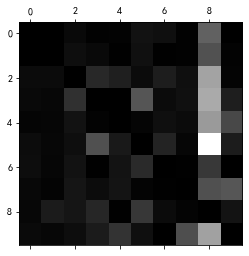

In [37]:
# 计算比例
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)  # 主对角线设为0，只看分类错误的情况
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

混淆矩阵分析：
- 每一行为真实值，每一列为预测值
- 第8列数值都比较大，说明有很多值被错误地识别为8
- 第8行比较暗，说明真实的数字8很少被分错

改进方案：
- 查看被错误地预测为8的图片
- 开发新特征：写一个算法识别图片中环的数量（8有两个环，9有一个环，5没有环）
